In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from scipy.stats import norm, skew
from scipy import stats

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score, train_test_split

from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer

import xgboost as xgb

In [2]:
def combined_dataset(targetName):
    train = pd.read_csv("data/train.csv")

    test = pd.read_csv("data/test.csv")
    train.drop(targetName, 1, inplace=True)
    combined = train.append(test)
    combined.reset_index(inplace=True)
    combined.drop('index', inplace=True, axis=1)
    
    return combined, train.shape[0]

In [3]:
combined, idx = combined_dataset('SalePrice')

In [4]:
# remove missing data

In [5]:
combined["PoolQC"].fillna("No", inplace=True)
combined["PoolArea"].fillna(0, inplace=True)
combined['MiscFeature'].fillna('None', inplace=True)
combined['Alley'].fillna('None', inplace=True)
combined['Fence'].fillna('None', inplace=True)
combined['FireplaceQu'].fillna('None', inplace=True)
combined['LotFrontage'].fillna(0, inplace=True)
combined['GarageYrBlt'].fillna(combined['YearBuilt'], inplace=True)
combined["GarageType"].fillna("None", inplace=True)
combined["GarageQual"].fillna("None", inplace=True)
combined["GarageCond"].fillna("None", inplace=True)
combined["GarageFinish"].fillna("None", inplace=True)
combined['BsmtFinType1'].fillna('None', inplace=True)
combined['BsmtFinType2'].fillna('None', inplace=True)
combined['BsmtExposure'].fillna('None', inplace=True)
combined['BsmtQual'].fillna('None', inplace=True)
combined['BsmtCond'].fillna('None', inplace=True)
combined['MasVnrType'].fillna('None', inplace=True)
combined['MasVnrArea'].fillna(0, inplace=True)
combined['Electrical'].fillna('None', inplace=True)
combined['GarageCars'].fillna(0, inplace=True)
combined['KitchenQual'].fillna(0, inplace=True)
combined['MSZoning'].fillna('None', inplace=True)
combined['Utilities'].fillna('None', inplace=True)
combined['Functional'].fillna('None', inplace=True)
combined['BsmtFullBath'].fillna(0, inplace=True)
combined['BsmtHalfBath'].fillna(0, inplace=True)
combined['Exterior1st'].fillna('None', inplace=True)
combined['Exterior2nd'].fillna('None', inplace=True)
combined['GarageArea'].fillna(0, inplace=True)
combined['BsmtFinSF2'].fillna(0, inplace=True)
combined['BsmtFinSF1'].fillna(0, inplace=True)
combined['SaleType'].fillna('None', inplace=True)
combined['TotalBsmtSF'].fillna(0, inplace=True)
combined['BsmtUnfSF'].fillna(0, inplace=True)

In [6]:
# create new features

# OverallQual

def classify_quality(x):
    if x <= 3.0:
        return 'low'
    elif x <= 5.0:
        return 'mid'
    else:
        return 'high'

combined['QualityCategory'] = combined.OverallQual.apply(classify_quality)

combined['TotalSF'] = combined['TotalBsmtSF'] + combined['1stFlrSF'] + combined['2ndFlrSF']

In [7]:
combined.isnull().sum().max()

0

In [8]:
# some numerical features are actually categories. 
def add_prefix(x):
    return 'SC' + str(x)

combined.MSSubClass = combined.MSSubClass.apply(add_prefix)

In [9]:
import calendar

combined['MoSold'] = combined['MoSold'].apply(lambda x: calendar.month_abbr[x])

In [10]:
categorical_features = combined.select_dtypes(include = ["object"]).columns
numerical_features = combined.select_dtypes(exclude = ["object"]).columns

In [11]:
# skewed variables

skewed_feats = combined[numerical_features].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness.head(10)


Skew in numerical features: 



,Skew
MiscVal,21.947195
PoolArea,16.898328
LotArea,12.822431
LowQualFinSF,12.088761
3SsnPorch,11.376065
KitchenAbvGr,4.302254
BsmtFinSF2,4.146143
EnclosedPorch,4.003891
ScreenPorch,3.946694
BsmtHalfBath,3.931594


In [12]:
skewness = skewness[abs(skewness) > 0.75]

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    #all_data[feat] += 1
    combined[feat] = boxcox1p(combined[feat], lam)

In [13]:
# convert all categorical variables into numeric

combined = pd.get_dummies(combined)

/Users/sergio/anaconda/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


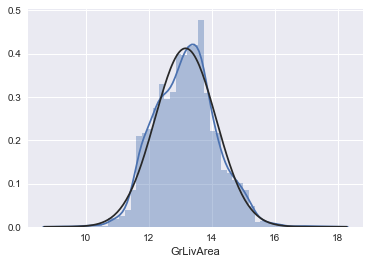

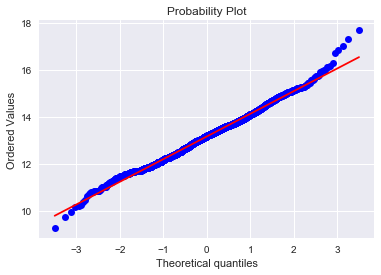

In [14]:
# skewed features

sns.distplot(combined['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(combined['GrLivArea'], plot=plt)

In [15]:
# combined['GrLivArea'] = np.log(combined['GrLivArea'])
# combined['HasBsmt'] = pd.Series(len(combined['TotalBsmtSF']), index=combined.index)
# combined['HasBsmt'] = 0 
# combined.loc[combined['TotalBsmtSF']>0,'HasBsmt'] = 1
# combined.loc[combined['HasBsmt']==1,'TotalBsmtSF'] = np.log(combined['TotalBsmtSF'])

In [16]:
# modeling

def get_original_datasets(idx, target):
    global combined
    
    train0 = pd.read_csv('data/train.csv')
    
    targets = train0[target]
    train = combined.head(idx)
    test = combined.iloc[idx:]
    
    return train, test, targets

train, test, targets = get_original_datasets(idx, 'SalePrice')
targets = np.log1p(targets)

In [17]:
train.drop('Id', inplace=True, axis=1)
test.drop('Id', inplace=True, axis=1)
train = train.drop(train[(train['GrLivArea']>4000) & (targets<300000)].index)
columns = train.columns

/Users/sergio/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/sergio/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [18]:
X_train, X_test, y_train, y_test = train_test_split(train, targets, test_size=0.3, random_state=0)

print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
print(targets.shape)

(1022, 340)
(438, 340)
(1022,)
(438,)
(1460,)


In [19]:
# methods for validation

# scorer = make_scorer(mean_squared_error, greater_is_better = False)

# def rmse_cv_train(model):
#     rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
#     return(rmse)

# def rmse_cv_test(model):
#     rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
#     return(rmse)

# def rmse_cv(model):
#     rmse= np.sqrt(-cross_val_score(model, X_train, y, scoring="neg_mean_squared_error", cv = 5))
#     return(rmse)

n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [20]:
model = xgb.XGBRegressor(colsample_bytree=0.4,
                gamma=0.045,
                learning_rate=0.07,
                max_depth=20,
                min_child_weight=1.5,
                n_estimators=150,
                reg_alpha=0.65,
                reg_lambda=0.45,
                subsample=0.95)

model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=0.4,
       gamma=0.045, learning_rate=0.07, max_delta_step=0, max_depth=20,
       min_child_weight=1.5, missing=None, n_estimators=150, nthread=-1,
       objective='reg:linear', reg_alpha=0.65, reg_lambda=0.45,
       scale_pos_weight=1, seed=0, silent=True, subsample=0.95)

In [21]:

lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005], )
lasso.fit(X_train, y_train)

LassoCV(alphas=[1, 0.1, 0.001, 0.0005], copy_X=True, cv=None, eps=0.001,
    fit_intercept=True, max_iter=1000, n_alphas=100, n_jobs=1,
    normalize=False, positive=False, precompute='auto', random_state=None,
    selection='cyclic', tol=0.0001, verbose=False)

In [22]:
# score = rmsle_cv(model)
# print("\Model score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

In [23]:
score = rmsle_cv(lasso)
print("\Model score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))
y_train_pred = lasso.predict(X_train)
y_test_pred = lasso.predict(X_test)

\Model score: 0.1223 (0.0181)



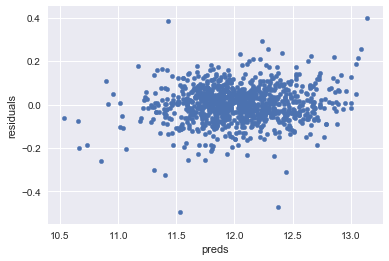

In [24]:
preds = pd.DataFrame({"preds":model.predict(X_train), "true":y_train})
preds["residuals"] = preds["true"] - preds["preds"]
preds.plot(x = "preds", y = "residuals",kind = "scatter")

In [27]:
pred_xg = model.predict(test)
pred_lasso = lasso.predict(test)

output = (pred_xg + pred_lasso) / 2
output = np.expm1(output)
df_output = pd.DataFrame()
aux = pd.read_csv('data/test.csv')
df_output['Id'] = aux['Id']
df_output['SalePrice'] = output

df_output[['Id','SalePrice']].to_csv('submissions/sn_submission.csv',index=False)